<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

MAHREZ Ali      
HENROT Adrien

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://codalab.lisn.upsaclay.fr/competitions/3739

* **Étape 1 :** S'enregistrer sur https://codalab.lisn.upsaclay.fr

* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://codalab.lisn.upsaclay.fr/competitions/3739#participate-get_starting_kit) "Participate > Files > Public Data".

* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
 !pip install imblearn

In [2]:
from datetime import datetime
from pathlib import Path
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [3]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

Le but du projet consiste à créer un modèle d'apprentissage à partir de données de personnes mortes ou non durant leur séjour à l'hôpital, pour faire des prédictions sur la survit des patients.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

Dans notre cas, balanced accuracy score est utilisé dans le cas où nous travaillons avec des données non égaux. Lorseque nous avons avons une données qui apparait plus que l'autre et que nous voulons les équilibrer.

## 2. Chargement des données

In [4]:
DATA = Path("~/Isd2/Projet/public_data").expanduser()
# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [5]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
x_df.head(3)

INSURANCE LANGUAGE      RELIGION MARITAL_STATUS ETHNICITY GENDER  AGE  \
0   Private     ENGL      CATHOLIC       DIVORCED     WHITE      F   21   
1   Private     ENGL  UNOBTAINABLE         SINGLE     WHITE      M   39   
2  Medicaid     SPAN      CATHOLIC        WIDOWED     OTHER      M   40   

   HR_MIN_DAY1  HR_MAX_DAY1  HR_MEAN_DAY1  ...  Eyeinfectn  Othereyedx  \
0         57.2          109          70.8  ...           0           0   
1         79.3          121          96.9  ...           0           0   
2          118          175           141  ...           0           0   

   Otitismedia  Dizziness  Othereardx  Othnervdx  Hrtvalvedx  Carditis  HTN  \
0            0          0           0          0           0         0    0   
1            0          0           0          0           0         0    0   
2            0          0           0          0           0         0    0   

   Htncomplicn  
0            0  
1            1  
2            0  

[3 rows x 337 columns]

C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [7]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [8]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [9]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

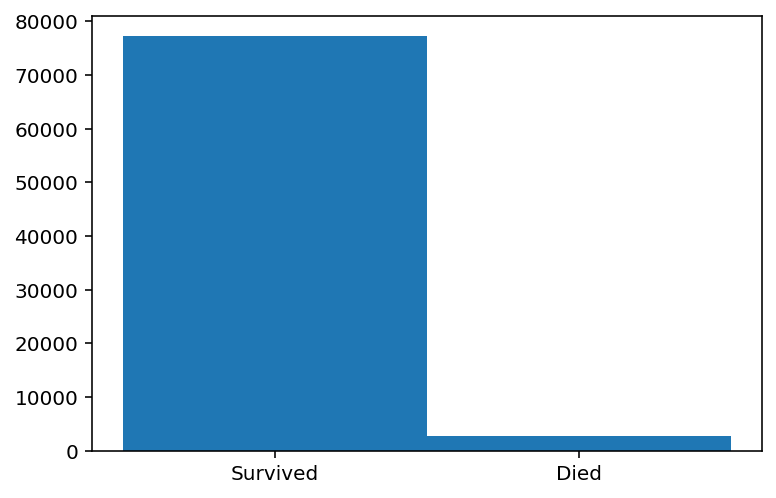

In [10]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

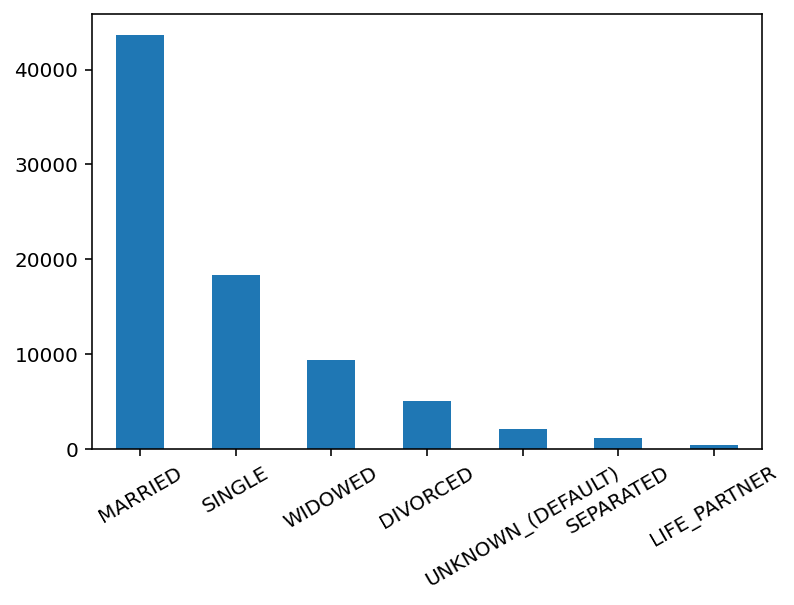

In [11]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

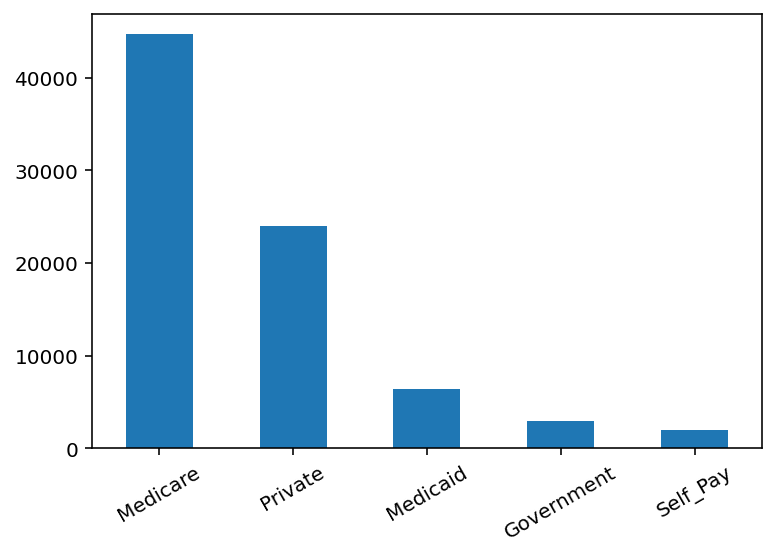

In [12]:
x_insurance_cnts = x_df["INSURANCE"].value_counts()
x_insurance_cnts.plot.bar(rot=30)
plt.show()

#### Corrélations

In [13]:
corr_df = x_df.corr()

corr_df.style.format("{:.2g}")

In [14]:
Col = x_df.columns
mesCoefs = []

for i in range(0,len(x_df.columns)):
    maCol = Col[i]
    monCoef = 0
    print("-------",maCol)
    
    if(isinstance(x_df[maCol][0], str)):
        we = x_df.iloc[:,i]
        label, level = pd.factorize(we)
        x_df['label'] = label
        if(np.abs(np.mean(np.array(x_df['label']))) < 10e-25) and (np.abs(np.std(np.array(x_df['label']))) < 10e-25):
            monCoef = 0
        else:
            monCoef = (np.corrcoef(np.array(ys),np.array(x_df['label']))[0,1])
    else:
        if(np.abs(np.mean(np.array(x_df[maCol]))) < 10e-25) and (np.abs(np.std(np.array(x_df[maCol]))) < 10e-25):
            monCoef = 0
        else:
            monCoef = (np.corrcoef(np.array(ys),np.array(x_df[maCol]))[0,1])
            
    mesCoefs.append(monCoef)    
    print(monCoef,"\n")


------- INSURANCE
0.039016336209527 

------- LANGUAGE
-0.016242368421003364 

------- RELIGION
0.0012734071431962839 

------- MARITAL_STATUS
-0.004346597000506125 

------- ETHNICITY
-0.0034645553436322024 

------- GENDER
-0.0200159686106844 

------- AGE
0.019190061831425857 

------- HR_MIN_DAY1
0.06477962995310105 

------- HR_MAX_DAY1
0.07259576333057106 

------- HR_MEAN_DAY1
0.06327310035113451 

------- SYS_BP_MIN_DAY1
-0.04931798215691219 

------- SYS_BP_MAX_DAY1
0.04500747432810111 

------- SYS_BP_MEAN_DAY1
0.0077772881685251646 

------- DIAS_BP_MIN_DAY1
-0.044902135819023734 

------- DIAS_BP_MAX_DAY1
0.03520157844957809 

------- DIAS_BP_MEAN_DAY1
-0.02422032239538734 

------- MEAN_BP_MIN_DAY1
-0.04118188890054431 

------- MEAN_BP_MAX_DAY1
0.0076848195357125905 

------- MEAN_BP_MEAN_DAY1
-0.016327250853351134 

------- RESP_RATE_MIN_DAY1
0.04508880897548057 

------- RESP_RATE_MAX_DAY1
0.09064894416456687 

------- RESP_RATE_MEAN_DAY1
0.09577105799902437 

------- T

In [15]:
#correlation entre la variable y et l'age, le nombre de jour minimum, maximum et moyen des patients à l'hopital
corr2_df = pd.DataFrame({"AGE": x_df["AGE"],"HR_MIN_DAY1": x_df["HR_MIN_DAY1"], "HR_MAX_DAY1": x_df["HR_MAX_DAY1"] , "HR_MEAN_DAY1": x_df["HR_MEAN_DAY1"]  })
corr2_df["YS"]=ys
corr2_df.corr()

AGE  HR_MIN_DAY1  HR_MAX_DAY1  HR_MEAN_DAY1     YS
AGE               1       -0.161        -0.14        -0.155 0.0192
HR_MIN_DAY1  -0.161            1        0.703         0.856 0.0648
HR_MAX_DAY1   -0.14        0.703            1         0.818 0.0726
HR_MEAN_DAY1 -0.155        0.856        0.818             1 0.0633
YS           0.0192       0.0648       0.0726        0.0633      1

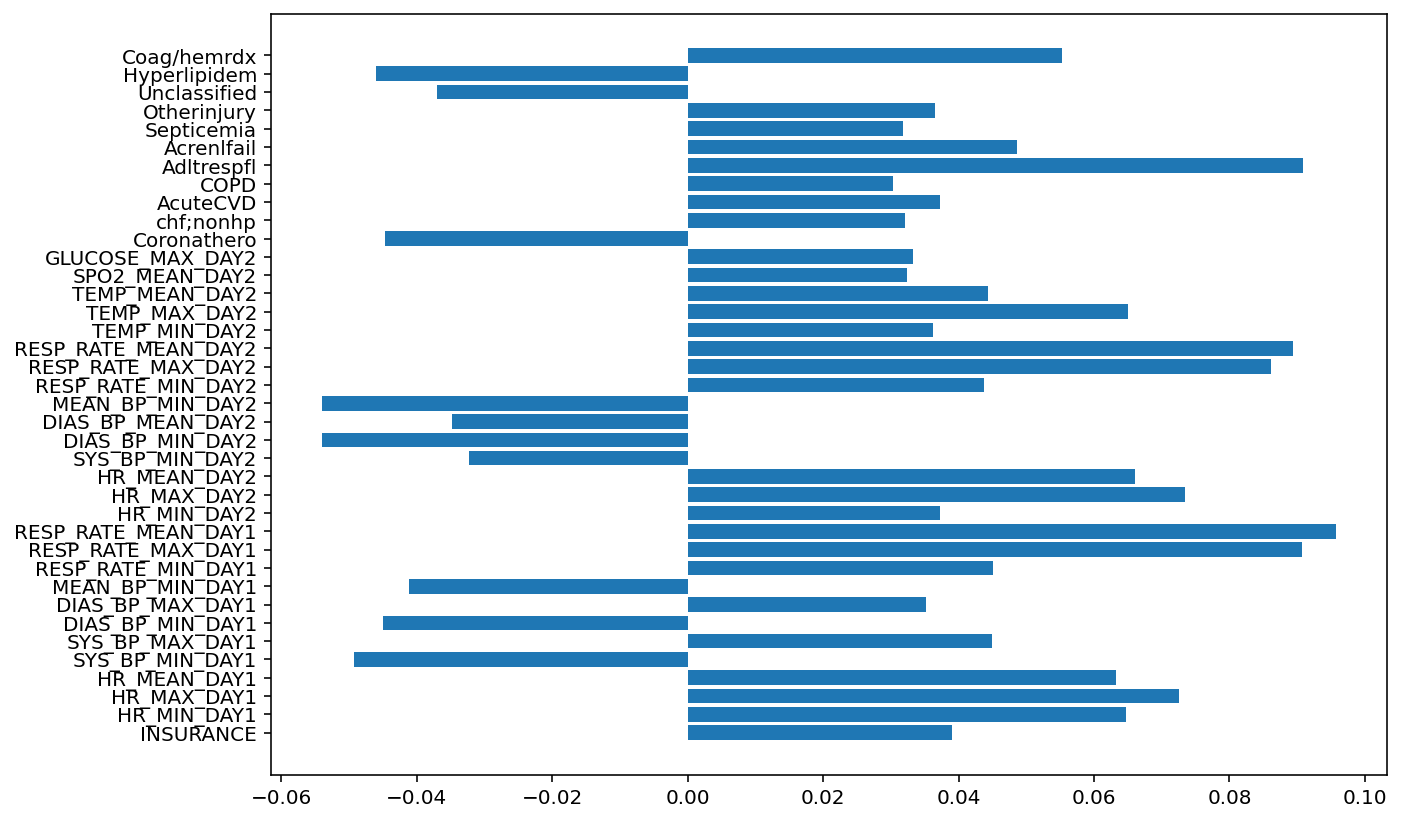

In [16]:
# TODO: Bar plot of the variables most correlated with y

w=np.where(np.abs(mesCoefs)>0.03)
plt.figure(figsize=(10,7))
plt.barh(Col[w],np.array(mesCoefs)[w])
plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

Nous avons jugé pertinant d'afficher les corrélations supérieurs à 0.03 pour améliorerr la visibilité du graphique.
On peut observer à partir du graphique que la corrélation maximal entre les variables et le résultats sont globalemet assez faible (la correlation maximal étant à environ 0.1).

#### Autres graphiques ou résultats d'une analyse exploratoire

-------
33
-------
8
-------
32
-------
44
-------
45
-------
20
-------
92
-------
21
-------
332
-------
287
-------


<Figure size 432x288 with 0 Axes>

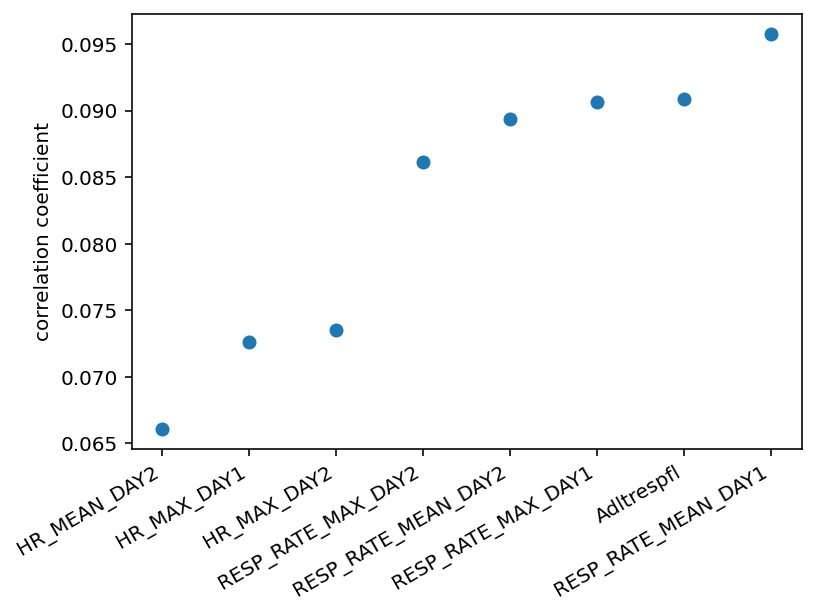

In [17]:
# TODO: Add graph

#mesCoefs
monArray=np.abs(np.array(mesCoefs))

temp = monArray.argsort()

plt.figure()
toplot=[]
name=[]

for i in temp[len(temp)-11:len(temp)-1]:
    print("-------")
    print(i)
    toplot.append(monArray[i])
    name.append(Col[i])
    
plt.figure()
plt.plot(name,toplot,"o")
plt.xticks(rotation=30,ha='right')
plt.ylabel("correlation coefficient")
print("-------")
plt.show()

Le graphique ci dessus représente les 10 meilleurs corrélations en valeur absolue

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [18]:
print(x_df.shape, x_test_df.shape)

(79999, 338) (20001, 337)


In [19]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [20]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [21]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

LANGUAGE MARITAL_STATUS    ICU  ECodes:Adverseeffectsofmedicalcare  \
2251      ENGL        MARRIED   MICU                                 NaN   
9983      ENGL        MARRIED   MICU                                   0   
10549     ENGL        MARRIED   MICU                                   0   
10831     ENGL        MARRIED   MICU                                 NaN   
17012     ENGL        MARRIED   CSRU                                 NaN   
23088     ENGL        MARRIED    NaN                                   0   
32539     ENGL            NaN   CSRU                                   0   
42762     ENGL         SINGLE  TSICU                                 NaN   
53191      NaN        MARRIED   MICU                                   0   
53390     CAPE        MARRIED    NaN                                   0   
56772     ENGL        MARRIED   CSRU                                 NaN   
61852     ENGL        MARRIED   SICU                                 NaN   
71511     ENGL        MARRIED  TSICU                                   0   

       Otnutritdx  Othnervdx  
2251            0          0  
9983          NaN          0  
10549         NaN          0  
10831           1          0  
17012           0          1  
23088           0          0  
32539           0          0  
42762           0          0  
53191           0          0  
53390           0          0  
56772           0          0  
61852           0          0  
71511           0        NaN

#### Remplacement des NAN

In [22]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [23]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [24]:
print(x_df.shape, x_test_df.shape)

(79999, 338) (20001, 337)


In [25]:
print(x_test_df["RELIGION"].value_counts())

CATHOLIC                  7517
NOT_SPECIFIED             3764
UNOBTAINABLE              2208
PROTESTANT_QUAKER         2208
JEWISH                    1855
OTHER                     1171
EPISCOPALIAN               338
CHRISTIAN_SCIENTIST        221
GREEK_ORTHODOX             216
BUDDHIST                   140
MUSLIM                      87
UNITARIAN-UNIVERSALIST      62
JEHOVAH'S_WITNESS           60
HINDU                       59
ROMANIAN_EAST._ORTH         42
7TH_DAY_ADVENTIST           32
BAPTIST                     16
HEBREW                       4
LUTHERAN                     1
Name: RELIGION, dtype: int64


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [26]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

In [27]:
# TODO: Other application of merge_rare_categories
Col2 = x_df.columns

for i in range(0,len(x_df.columns)):
    maCol = Col2[i]
    
    if(isinstance(x_df[maCol][0], str)):
        we = x_df.iloc[:,i]
        label, level = pd.factorize(we)
        if(len(label) > 10):
            print("---------")
            merge_rare_categories([x_df, x_test_df], col = maCol,keep_n = 5)
            print(x_test_df[maCol].value_counts(),"\n")

---------
Index(['Medicare', 'Private', 'Medicaid', 'Government', 'Self_Pay'], dtype='object')
Medicare      11250
Private        5896
Medicaid       1585
Government      721
Self_Pay        549
Name: INSURANCE, dtype: int64 

---------
Index(['ENGL', 'SPAN', 'RUSS', 'PTUN', 'CANT'], dtype='object')
ENGL     18883
OTHER      485
SPAN       258
RUSS       151
PTUN       147
CANT        77
Name: LANGUAGE, dtype: int64 

---------
Index(['CATHOLIC', 'NOT_SPECIFIED', 'OTHER', 'UNOBTAINABLE',
       'PROTESTANT_QUAKER'],
      dtype='object')
CATHOLIC             7517
OTHER                4304
NOT_SPECIFIED        3764
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
Name: RELIGION, dtype: int64 

---------
Index(['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'UNKNOWN_(DEFAULT)'], dtype='object')
MARRIED              10856
SINGLE                4635
WIDOWED               2400
DIVORCED              1217
UNKNOWN_(DEFAULT)      497
OTHER                  396
Name: MARITAL_STATUS, dtype: int64

### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [28]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [29]:
x_df.head(5)

INSURANCE LANGUAGE       RELIGION MARITAL_STATUS              ETHNICITY  \
0   Private     ENGL       CATHOLIC       DIVORCED                  WHITE   
1   Private     ENGL   UNOBTAINABLE         SINGLE                  WHITE   
2  Medicaid     SPAN       CATHOLIC        WIDOWED                  OTHER   
3  Medicare     ENGL  NOT_SPECIFIED        MARRIED                  WHITE   
4  Medicare     ENGL   UNOBTAINABLE        MARRIED  UNKNOWN/NOT_SPECIFIED   

  GENDER  AGE  HR_MIN_DAY1  HR_MAX_DAY1  HR_MEAN_DAY1  ...  Othereyedx  \
0      F   21         57.2          109          70.8  ...           0   
1      M   39         79.3          121          96.9  ...           0   
2      M   40          118          175           141  ...           0   
3      M   75         83.8         89.2          86.1  ...           0   
4      F   55         60.9          106          80.6  ...           0   

   Otitismedia  Dizziness  Othereardx  Othnervdx  Hrtvalvedx  Carditis  HTN  \
0            0          0           0          0           0         0    0   
1            0          0           0          0           0         0    0   
2            0          0           0          0           0         0    0   
3            0          0           0          0           0         0    1   
4            0          0           0          0           0         0    0   

   Htncomplicn  label  
0            0      0  
1            1      1  
2            0      2  
3            0      1  
4            0      2  

[5 rows x 338 columns]

In [30]:
print(x_df.shape, ys.shape)

(79999, 338) (79999,)


In [31]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [32]:
x_fact_df.head(5)

INSURANCE  LANGUAGE  RELIGION  MARITAL_STATUS  ETHNICITY  GENDER  AGE  \
0          0         0         0               0          0       0   21   
1          0         0         1               1          0       1   39   
2          1         1         0               2          1       1   40   
3          2         0         2               3          0       1   75   
4          2         0         1               3          2       0   55   

   HR_MIN_DAY1  HR_MAX_DAY1  HR_MEAN_DAY1  ...  Othereyedx  Otitismedia  \
0         57.2          109          70.8  ...           0            0   
1         79.3          121          96.9  ...           0            0   
2          118          175           141  ...           0            0   
3         83.8         89.2          86.1  ...           0            0   
4         60.9          106          80.6  ...           0            0   

   Dizziness  Othereardx  Othnervdx  Hrtvalvedx  Carditis  HTN  Htncomplicn  \
0          0           0          0           0         0    0            0   
1          0           0          0           0         0    0            1   
2          0           0          0           0         0    0            0   
3          0           0          0           0         0    1            0   
4          0           0          0           0         0    0            0   

   label  
0      0  
1      1  
2      2  
3      1  
4      2  

[5 rows x 338 columns]

In [33]:
x_test_fact_df.head(3)

INSURANCE  LANGUAGE  RELIGION  MARITAL_STATUS  ETHNICITY  GENDER  AGE  \
0          3         0         3               3          0       0   18   
1          2         0         2               1          3       0   56   
2          1         0         0               1          0       1   32   

   HR_MIN_DAY1  HR_MAX_DAY1  HR_MEAN_DAY1  ...  Eyeinfectn  Othereyedx  \
0         72.6          113          96.5  ...           0           0   
1         66.6          107          83.8  ...           0           0   
2         69.7          103          87.3  ...           0           0   

   Otitismedia  Dizziness  Othereardx  Othnervdx  Hrtvalvedx  Carditis  HTN  \
0            0          0           0          0           0         0    0   
1            0          0           0          0           0         0    1   
2            0          0           0          0           0         0    0   

   Htncomplicn  
0            0  
1            0  
2            0  

[3 rows x 337 columns]

#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [34]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'OTHER': 5}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [35]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_oh_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_oh_df = x_all_oh_df.iloc[: len(x_df)].copy()
x_test_oh_df = x_all_oh_df.iloc[len(x_df):].copy()
#
print(x_df.shape, x_test_df.shape)
print(x_oh_df.shape, x_test_oh_df.shape)
# Encode binary features on a single column (no need for 1-hot)
#label_encode(x_df, x_test_df, only_binary=True)

#x_all_oh_df = pd.get_dummies(pd.concat([x, x_test_df]))

#x_oh_df = x_all_oh_df.iloc[: len(x)].copy()
#x_test_oh_df = x_all_oh_df.iloc[len(x):].copy()

#print(x.shape, x_test_df.shape)
#print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 338) (20001, 337)
(79999, 364) (20001, 364)


#### Suppression des variables à valeur unique (constantes)

In [36]:
const_cols = {col for col in x_oh_df if len(x_oh_df[col].unique()) == 1}
len(const_cols)

173

In [37]:
x_oh_df.drop(const_cols, axis="columns", inplace=True)
x_test_oh_df.drop(const_cols, axis="columns", inplace=True)

print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 191) (20001, 191)


In [38]:
unique, frequency = np.unique(ys, return_counts = True)
print("Unique Values:", unique) 
print("Frequency Values:", frequency)

Unique Values: [0 1]
Frequency Values: [77202  2797]


### Création de l'ensemble de validation

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

In [39]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(x_oh_df, ys)
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(x_oh_df, ys)

In [40]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    #x_oh_df, ys, test_size=0.3
    X_rus, y_rus, test_size=0.3
)
x_train2, x_valid2, y_train2, y_valid2 = model_selection.train_test_split(
    #x_oh_df, ys, test_size=0.3
    X_ros, y_ros, test_size=0.3
)
# VARS: x_df, x_fact_df, x_oh_df

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_valid_scaled = scaler.transform(x_valid)
X_train_scaled2 = scaler.transform(x_train2)
X_valid_scaled2 = scaler.transform(x_valid2)

In [42]:
# TODO: PCA
N_COMP = 2

pca = decomposition.PCA(n_components=N_COMP)
xps_train = pca.fit_transform(X_train_scaled)
xps_test = pca.fit_transform(X_valid_scaled)
xps_train2 = pca.fit_transform(X_train_scaled2)
xps_test2 = pca.fit_transform(X_valid_scaled2)
#print(X_train_scaled.shape, X_valid_scaled.shape)
print("under-sampling")
print(xps_train.shape, xps_test.shape)
print(y_train.shape, y_valid.shape)
print("over-sampling")
print(xps_train2.shape, xps_test2.shape)
print(y_train2.shape, y_valid2.shape)

under-sampling
(3915, 2) (1679, 2)
(3915,) (1679,)
over-sampling
(108082, 2) (46322, 2)
(108082,) (46322,)


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

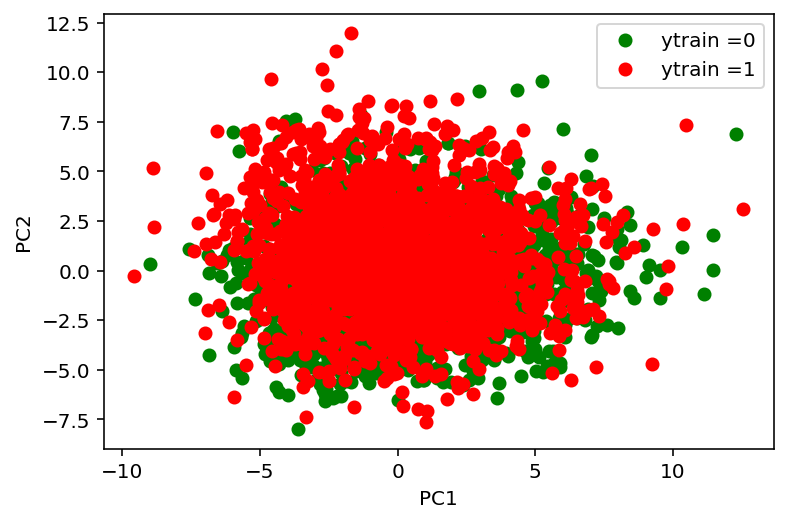

In [43]:
# TODO: Plot

Test=True
if(Test):
    x2D = xps_train[0]
    first_2D = pd.DataFrame(data = xps_train, columns = ['principal component 1', 'principal component 2'])
    my_first_1=[]
    my_second_1=[]

    my_first_2=[]
    my_second_2=[]

    for i in range(0,len(first_2D.iloc[:,0])):
            if y_train.iloc[i] ==0 :
                my_first_1.append(first_2D.iloc[i,0])
                my_second_1.append(first_2D.iloc[i,1])
            else:
                my_first_2.append(first_2D.iloc[i,0])
                my_second_2.append(first_2D.iloc[i,1])

    plt.plot(my_first_1,my_second_1,"o",color="green",label="ytrain =0")
    plt.plot(my_first_2,my_second_2,"o",color="red",label="ytrain =1")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    

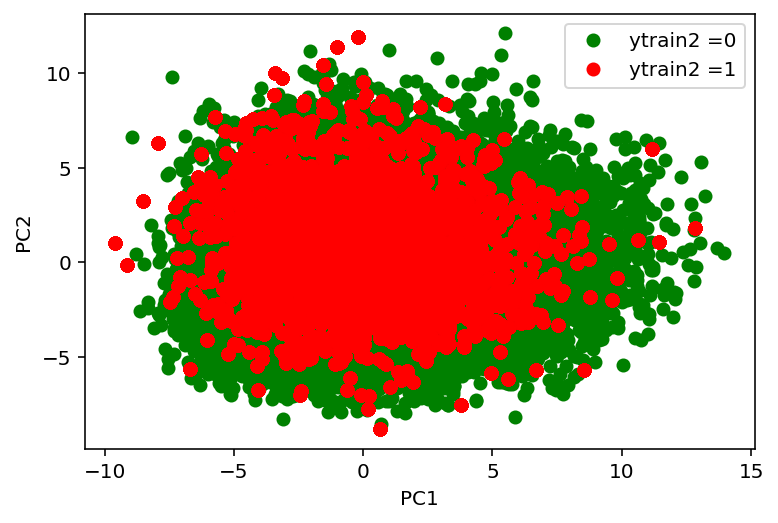

In [44]:
Test=True
if(Test):
    x2D = xps_train[0]
    first_2D = pd.DataFrame(data = xps_train2, columns = ['principal component 1', 'principal component 2'])
    my_first_1=[]
    my_second_1=[]

    my_first_2=[]
    my_second_2=[]

    for i in range(0,len(first_2D.iloc[:,0])):
            if y_train2.iloc[i] ==0 :
                my_first_1.append(first_2D.iloc[i,0])
                my_second_1.append(first_2D.iloc[i,1])
            else:
                my_first_2.append(first_2D.iloc[i,0])
                my_second_2.append(first_2D.iloc[i,1])

    plt.plot(my_first_1,my_second_1,"o",color="green",label="ytrain2 =0")
    plt.plot(my_first_2,my_second_2,"o",color="red",label="ytrain2 =1")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()

D'après la décomposition PCA en deux composantes principales, nous avons tracé ce graphique (plot) montrant en vert les vivants et en rouge les morts, nous observons que les nuages de points sont mélangés ce qui ne permet pas de discriminer les vivants des morts.

In [45]:
model_pca = naive_bayes.GaussianNB()
model_pca.fit(xps_train, y_train)
yps_pred = model_pca.predict(xps_test)
model_pca2 = naive_bayes.GaussianNB()
model_pca2.fit(xps_train2, y_train2)
yps_pred2 = model_pca.predict(xps_test2)

In [46]:
score = metrics.accuracy_score(y_valid, yps_pred)
print("under-sampling")
print(f"{score :.04f}")
score2 = metrics.accuracy_score(y_valid2, yps_pred2)
print("over-sampling")
print(f"{score2 :.04f}")

under-sampling
0.6325
over-sampling
0.5977


In [47]:
print("under-sampling")
print(metrics.classification_report(y_valid, yps_pred))
print("------------------------------------------------------------")
print("over-sampling")
print(metrics.classification_report(y_valid2, yps_pred2))

under-sampling
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       855
           1       0.66      0.52      0.58       824

    accuracy                           0.63      1679
   macro avg       0.64      0.63      0.63      1679
weighted avg       0.64      0.63      0.63      1679

------------------------------------------------------------
over-sampling
              precision    recall  f1-score   support

           0       0.58      0.71      0.64     23159
           1       0.63      0.49      0.55     23163

    accuracy                           0.60     46322
   macro avg       0.60      0.60      0.59     46322
weighted avg       0.60      0.60      0.59     46322



In [48]:
print("under-sampling")
unique, frequency = np.unique(y_train, return_counts = True)
print("Unique Values:", unique) 
print("Frequency Values:", frequency)
print("over-sampling")
unique2, frequency2 = np.unique(y_train2, return_counts = True)
print("Unique Values:", unique2) 
print("Frequency Values:", frequency2)

under-sampling
Unique Values: [0 1]
Frequency Values: [1942 1973]
over-sampling
Unique Values: [0 1]
Frequency Values: [54043 54039]


## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [49]:
SCORINGS = "balanced_accuracy"

In [50]:
from sklearn.tree import DecisionTreeClassifier
model = linear_model.LogisticRegression()
model2 = ensemble.RandomForestClassifier(n_estimators=10)
#model = ensemble.RandomForestClassifier(n_estimators=10)
from sklearn.linear_model import SGDClassifier
# TODO: Try other models
#model = DecisionTreeClassifier()
#model = naive_bayes.GaussianNB()

model.fit(x_train, y_train)  # training
model2.fit(x_train2, y_train2)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(n_estimators=10)

## 6. Évaluations

In [51]:
y_pred = model.predict(x_valid)  # predictions
score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring
print("under-sampling")
print(f"Balanced accuracy score: {score:.3g}")
#y_valid.value_counts()

y_pred2 = model2.predict(x_valid2)  # predictions
score2 = metrics.balanced_accuracy_score(y_valid2, y_pred2)  # scoring
print("over-sampling")
print(f"Balanced accuracy score: {score2:.3g}")
#y_valid2.value_counts()

under-sampling
Balanced accuracy score: 0.741
over-sampling
Balanced accuracy score: 1


### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [52]:
CV = 30
SCORING = "balanced_accuracy"

In [53]:
# TODO: Cross-Validation
pca = decomposition.PCA(n_components=CV)
model = linear_model.LogisticRegression() 

pipe = pipeline.Pipeline(steps=[("pca", pca), ("model", model)])

scores = model_selection.cross_val_score(pipe, X_rus, y_rus, cv=15, scoring=SCORINGS)
print("under-sampling")
with np.printoptions(precision=3):
    print(scores)
    
print(f"\n{SCORINGS}: {scores.mean():.2f}, with std dev: {scores.std():.2f}\n")

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


under-sampling
[0.697 0.735 0.681 0.7   0.711 0.686 0.716 0.708 0.694 0.735 0.692 0.727
 0.697 0.716 0.715]

balanced_accuracy: 0.71, with std dev: 0.02



* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

In [54]:
pca = decomposition.PCA(n_components=CV)
model2 = ensemble.RandomForestClassifier(n_estimators=10)
pipe = pipeline.Pipeline(steps=[("pca", pca), ("model", model2)])
scores2 = model_selection.cross_val_score(pipe, X_ros, y_ros, cv=15, scoring=SCORINGS)
print("over-sampling")
with np.printoptions(precision=3):
    print(scores2)

print(f"\n{SCORINGS}: {scores2.mean():.2f}, with std dev: {scores2.std():.2f}\n")

over-sampling
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

balanced_accuracy: 1.00, with std dev: 0.00



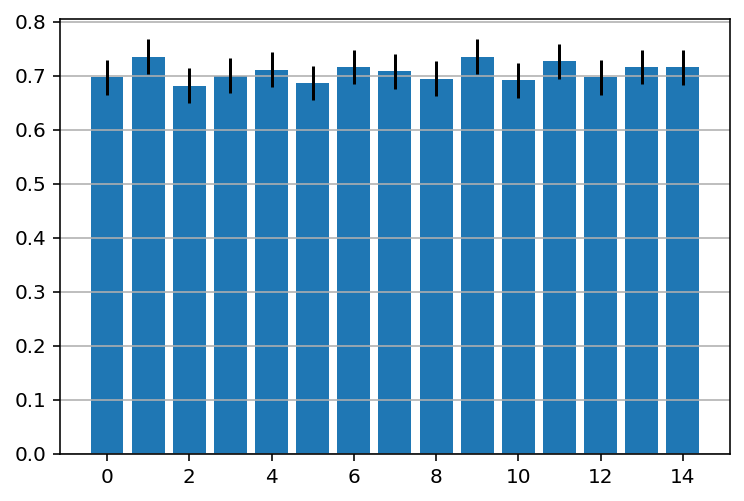

In [55]:
# TODO: Boxplot ou Barplot
plt.bar(range(len(scores)), scores, yerr=2 * scores.std())
plt.grid(axis="y")
plt.show()

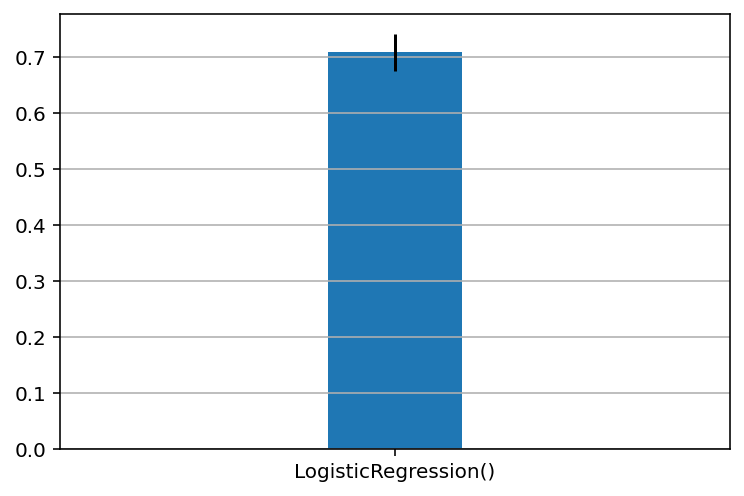

In [56]:
plt.bar([str(model)], scores.mean(), yerr=2 * scores.std())
plt.xlim(-2, 2)
plt.grid(axis="y")
plt.show()

Nous pouvons voir à partir du premier barplot qu'il représente les differents résultats de la crossValidations. Nous pouvons remarquer que l'estimations du taux d'erreur est assez faible vu qu'elle est representé par la petite barre noire.

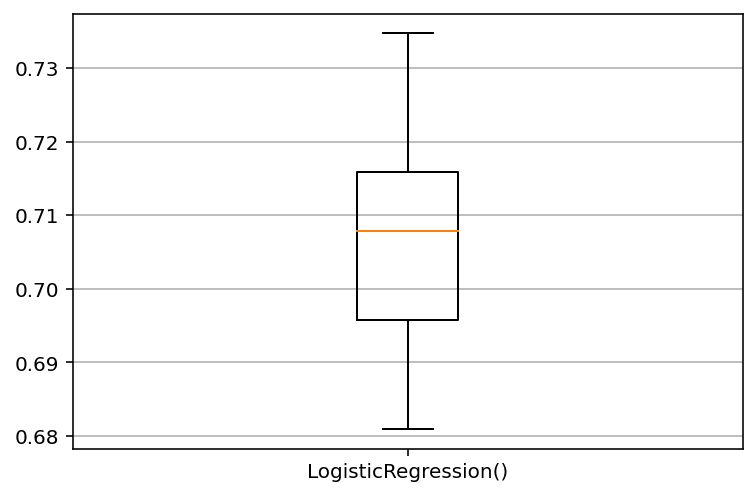

In [57]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()

à partir du boxplot, nous pouvons voir les differentes valeurs obtenues à partir de la cross-validation. La valeur minimal est celle obtenue par le lower extreme et la valeur maximal est obtenue à partir du upper extreme. La median est obtenue par la ligne rouge ...

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

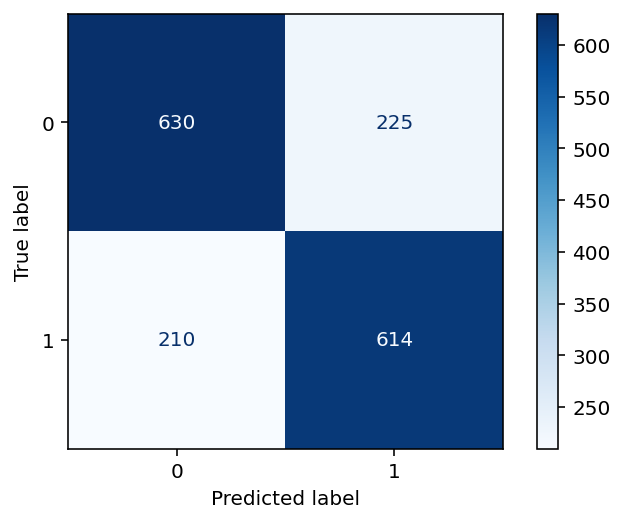

In [58]:
# TODO: Confusion Mtx
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred, cmap=plt.cm.Blues
)

Cette matrice de confusion represente les données under-sample, nous pouvons observer que ca correspond plus ou moins à nos résultat accuracy. En effet nous pouvons voir que les TP et TN representent la majorité des résultats.

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

In [59]:
# TODO: ROC
import sklearn
sklearn.metrics.roc_auc_score(y_valid, y_pred)

0.7409938681655596

Nous pouvons aussi remarquer que la ROC concorde avec les prédictions obtenues.

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

In [60]:
# TODO: Data augmentation
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)
scores = model_selection.cross_val_score(pipe, X_rus, y_rus, cv=15, scoring=SCORINGS)

with np.printoptions(precision=3):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.2f}, with std dev: {scores.std():.2f}\n")

[0.777 0.764 0.74  0.775 0.756 0.748 0.743 0.772 0.759 0.78  0.719 0.751
 0.743 0.775 0.769]

balanced_accuracy: 0.76, with std dev: 0.02



### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

Le meilleur résultat obtenue est : 0.75
Nous avons essayé differents model, le meilleur a été jusqu'à présent le Decision Tree avec un score de 0.57 mais nous avons remarqué que les données étaient assez imbalancé, en effet après analyse nous avons vu que la proportion des gens mort était d'environ de 2000 et des patient vivant était de 75000, nous avons donc décidé de resample nos données. Pour cela nous avons utilisé deux manière:
- La première est le over-sampling qui consiste à générer des données dans les classes sous-representés (dans notre cas les patients morts) et avec lequelle nous avons eu un score de 0.97 avec le Decision Tree, 1.00 avec le Random Forest, nous nous sommes dis que l'algorithme a propablement overfit.
- La deuxième méthode est le under-sampling qui consiste à enlever des données dans la classe la plus représenté pour équilibré le jeu. Nous avons obtenue une moyenne de score de 0.70 mais avec la data augmentation, le score s'est amélioré à 0.75. 

De manière générale, le DecisionTree ainsi que le Random Forest ont pris un peu plus de temps que le LinearLogisticRegression

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

Le sur-échantillonage permet de selectionner plus d'échantillons d'une classe par rapport a l'autre pour compenser le non-équilibre présent dans les données analysées. Pour cela le sur-échantillonage duplique des échantillons de la classe la moins représenté (contrairement au sous-échantillonnage qui lui supprime des datas de la classe la plus représentée).

Dans ce probleme cela pourrait etre utile pour équilibrer le nombre de morts par rapport au nombre de vivants (environ 75 000 datas pour les vivants contre 5 000 pour les morts). Et ainsi pouvoir analyser un dataset plus équilibré.

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_oh_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [63]:
predictions = model.predict(x_test_oh_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_oh_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---